In [1]:
# std lib
from collections import OrderedDict
from getpass import getpass
import warnings
from matplotlib.colors import LogNorm
import os
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs, stats
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from photutils import find_peaks
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import healpy as hp
from sklearn.cluster import DBSCAN

%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert
from dl.helpers.crossmatch import xmatch

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

In [2]:
# To save to virtual space, need to log in your account (not anonymous)
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  

Enter user name (+ENTER): zilishen
Enter password (+ENTER): ········


In [3]:
# create a proper WCS object
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

# Read in the data

We calculated the df['pix'] column from healpix with nside = 4, npix = 196

but the DES coverage is 46 pixels, and we ran DBscan for each of the pixels on TACC.

The DBscan clustering algorithm puts a label for each star (in dbscan_labels/*.npy), -1 for noise, 1~n for the cluster id.

In [23]:
df = pd.read_csv('des_dr1_g_i_small_box_hpix_4.csv')

In [67]:
input_dir = '../dbscan_labels/'
all_files = os.listdir(input_dir)
plot_dir = './DBscan_plots/' #make a directory for plot storage if you don't have one!

In [68]:
unique_pixels = np.unique(df['pix'])
print('Number of pixels in this dataset coverage: {}'.format(len(unique_pixels)))

Number of pixels in this dataset coverage: 46


In [69]:
clusters_list = []
for fi in all_files:
    labels = np.load(result_dir+fi)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    clusters_list.append(n_clusters_)
print ('Total number of clusters: {}'.format(np.sum(np.array(clusters_list))))

Total number of clusters: 1769


Estimated number of clusters in pixel 102: 40
Estimated number of clusters in pixel 103: 4
Estimated number of clusters in pixel 104: 2
Estimated number of clusters in pixel 105: 18
Estimated number of clusters in pixel 106: 9
Estimated number of clusters in pixel 107: 1
Estimated number of clusters in pixel 118: 2
Estimated number of clusters in pixel 120: 19
Estimated number of clusters in pixel 121: 33
Estimated number of clusters in pixel 122: 13
Estimated number of clusters in pixel 123: 71
Estimated number of clusters in pixel 136: 11
Estimated number of clusters in pixel 137: 37
Estimated number of clusters in pixel 138: 49
Estimated number of clusters in pixel 139: 61
Estimated number of clusters in pixel 140: 151
Estimated number of clusters in pixel 150: 1
Estimated number of clusters in pixel 151: 1
Estimated number of clusters in pixel 152: 38
Estimated number of clusters in pixel 153: 30
Estimated number of clusters in pixel 154: 59
Estimated number of clusters in pixel 15

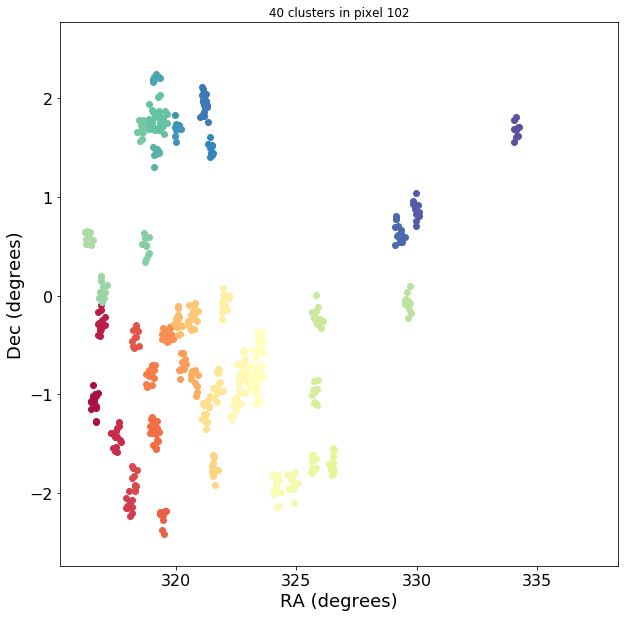

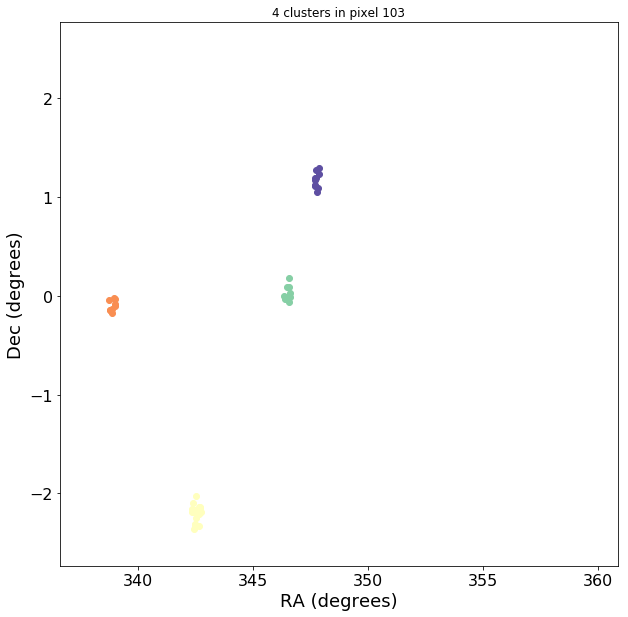

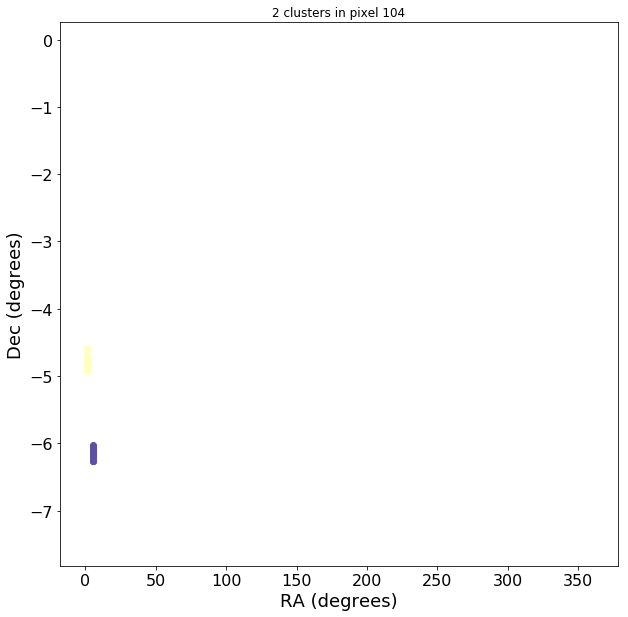

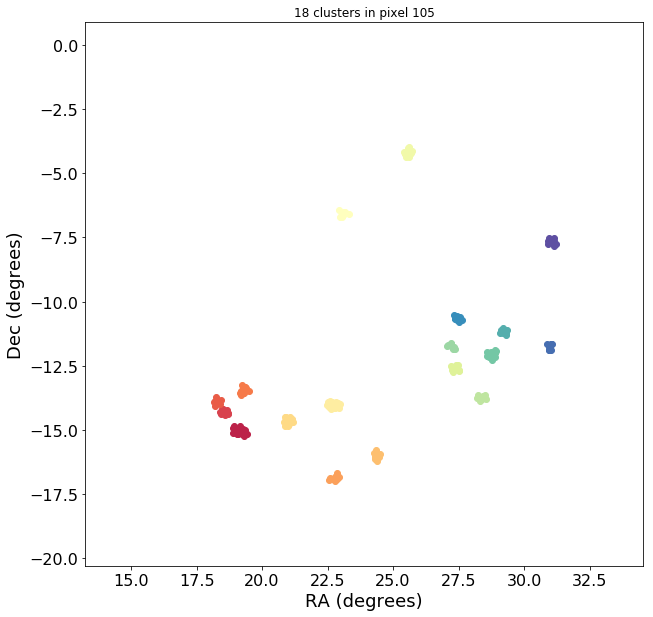

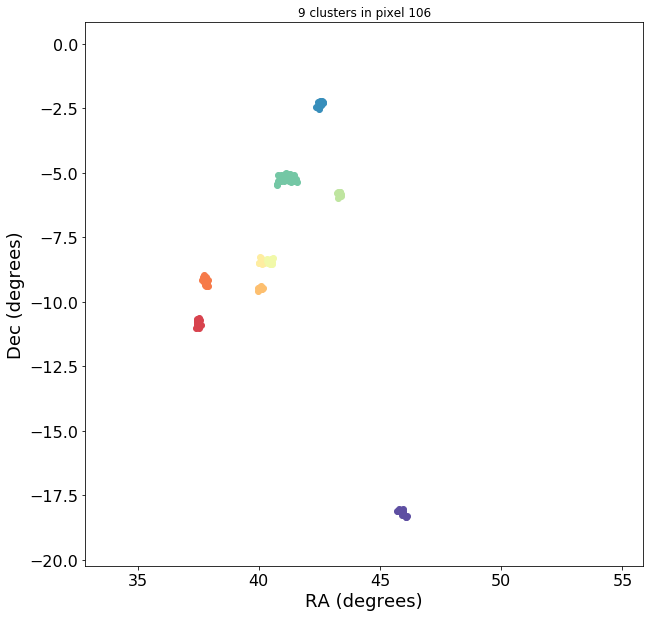

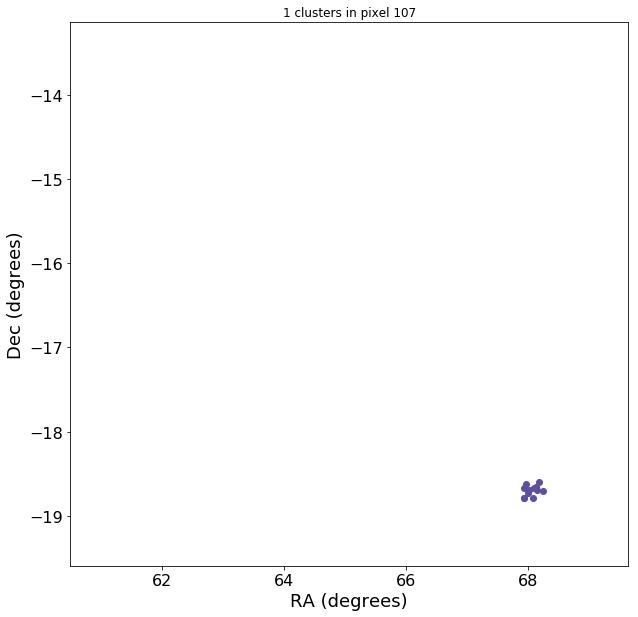

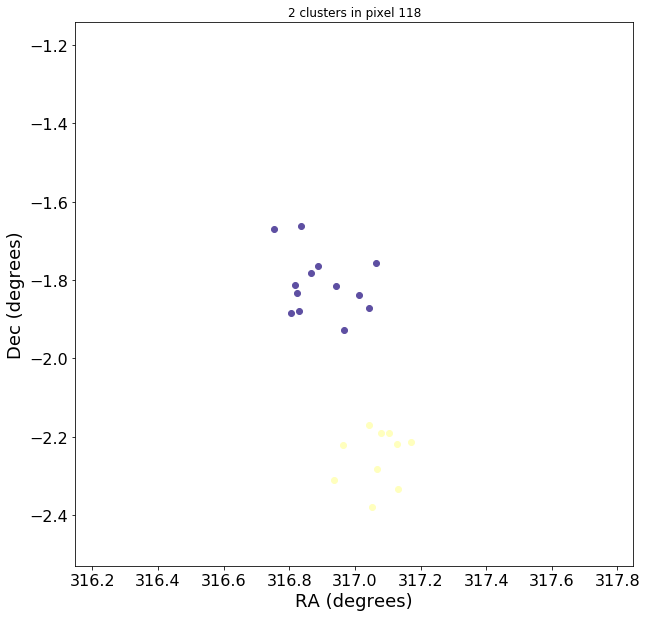

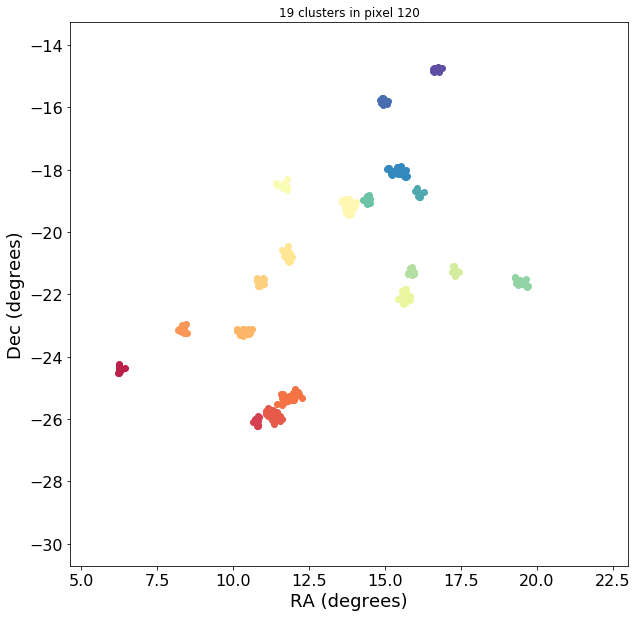

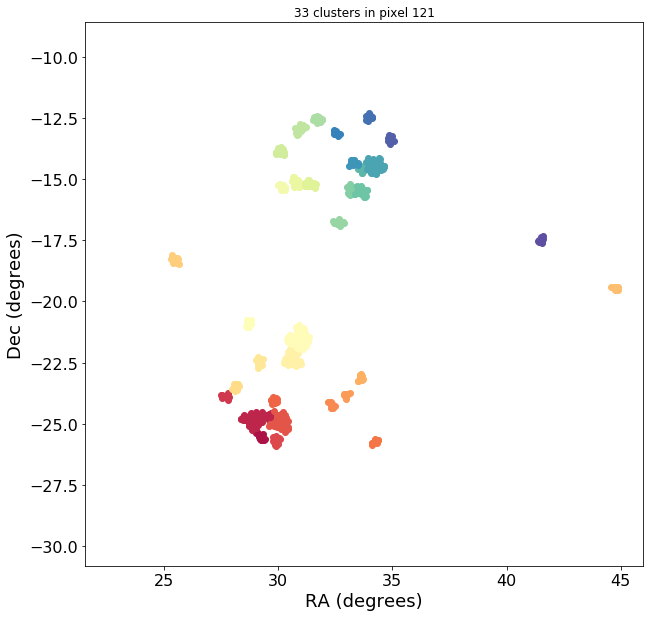

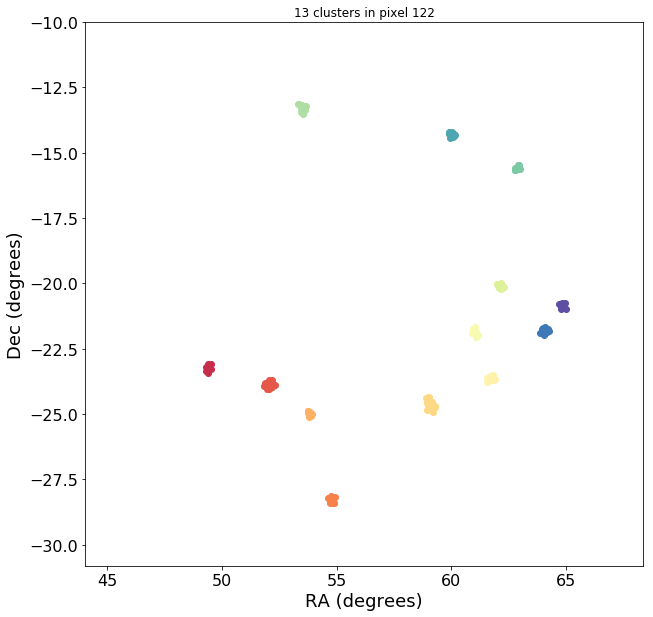

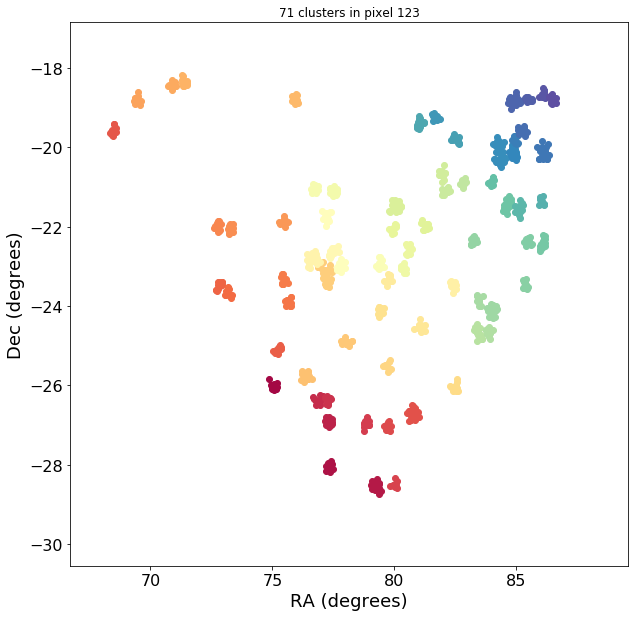

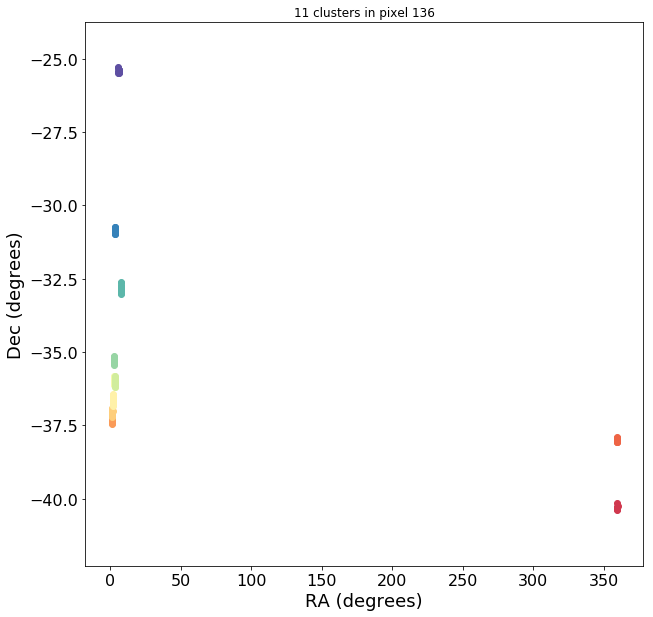

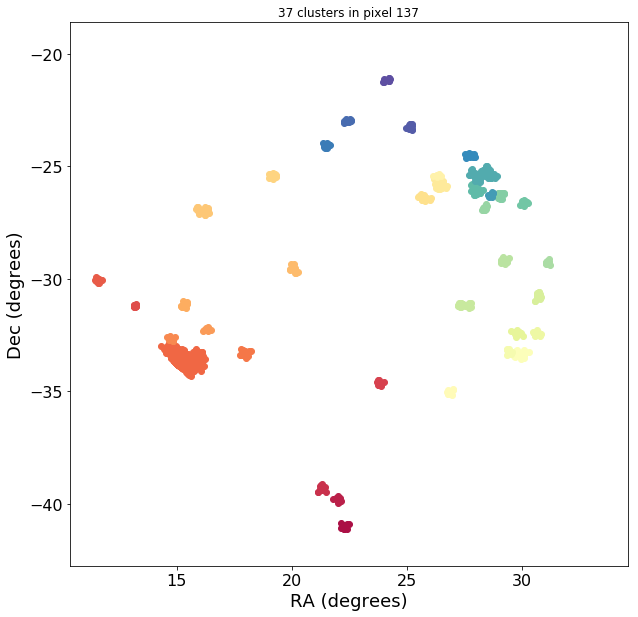

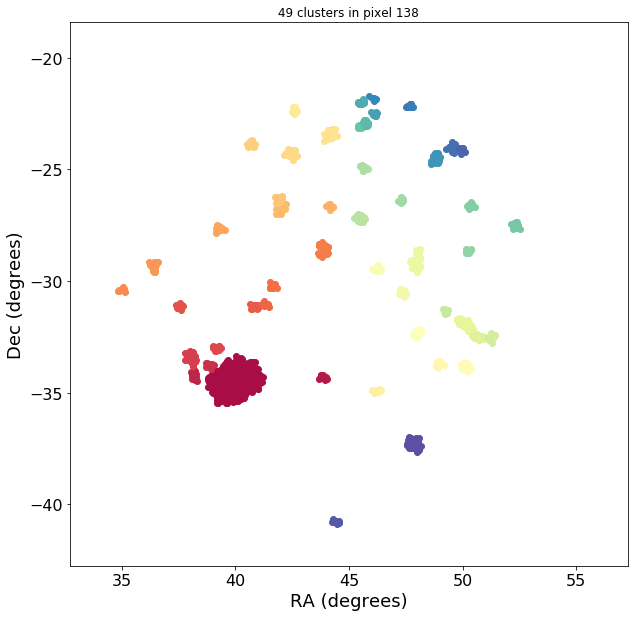

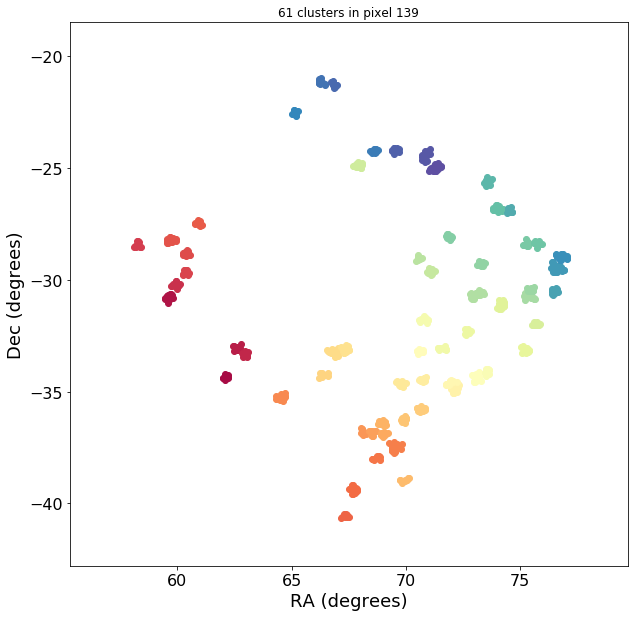

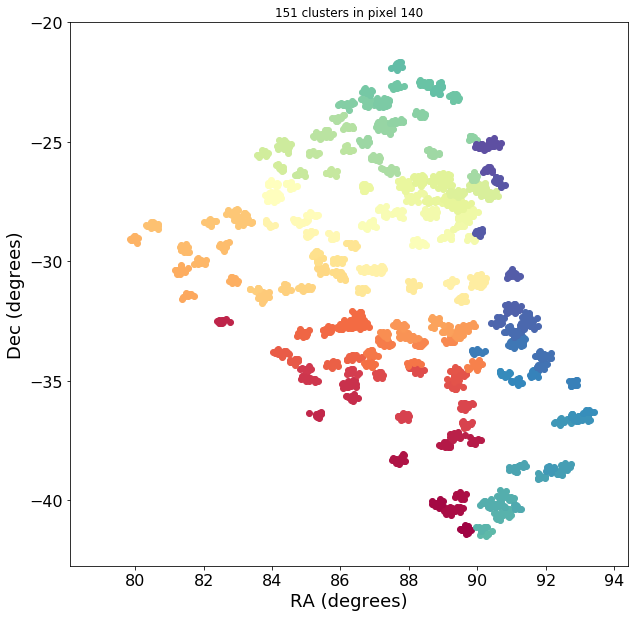

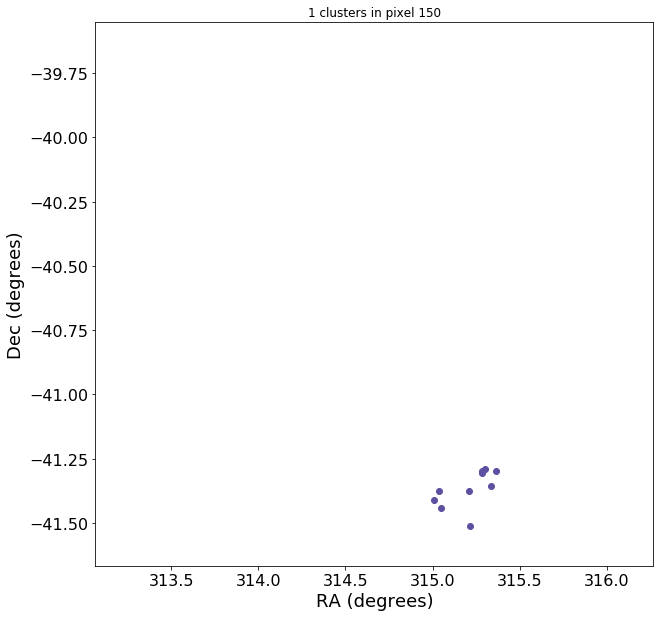

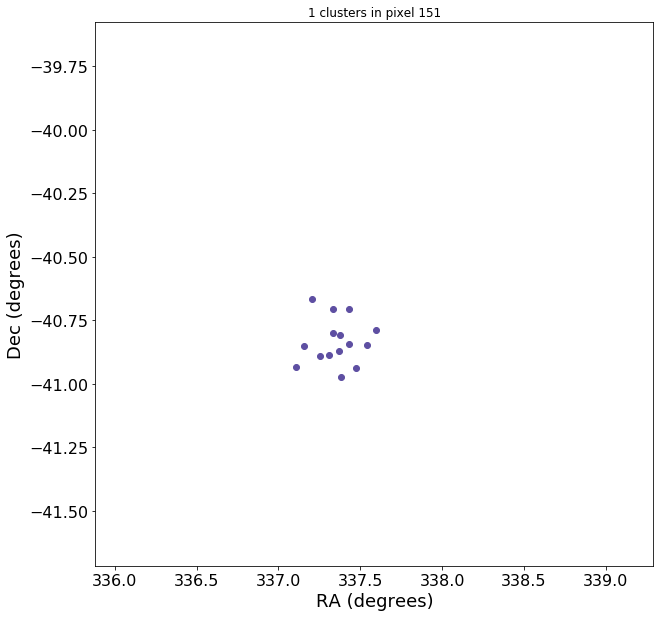

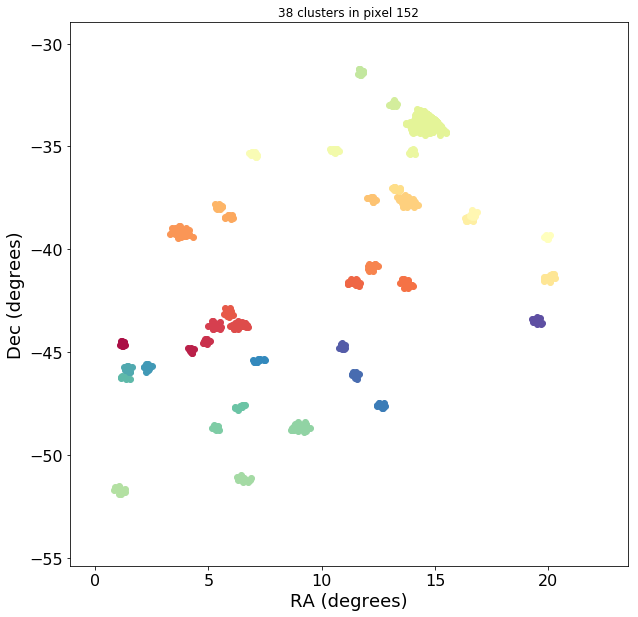

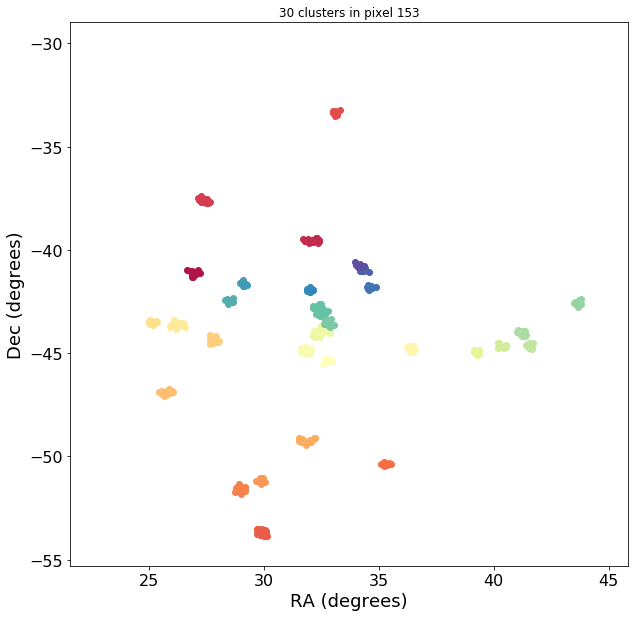

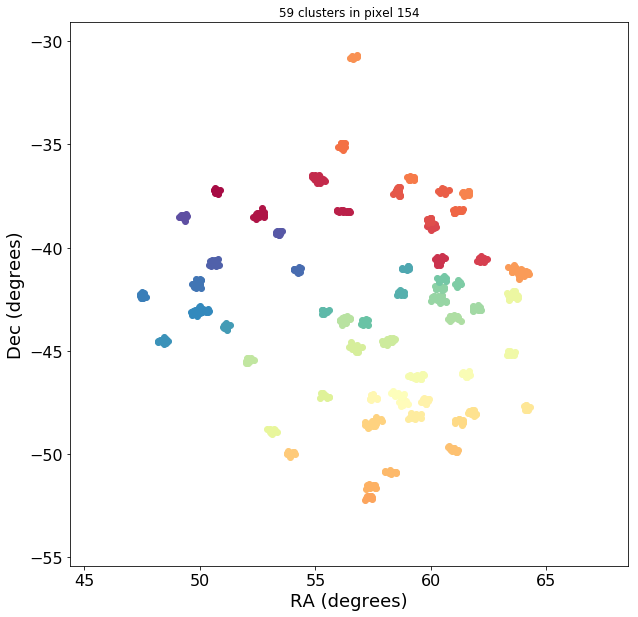

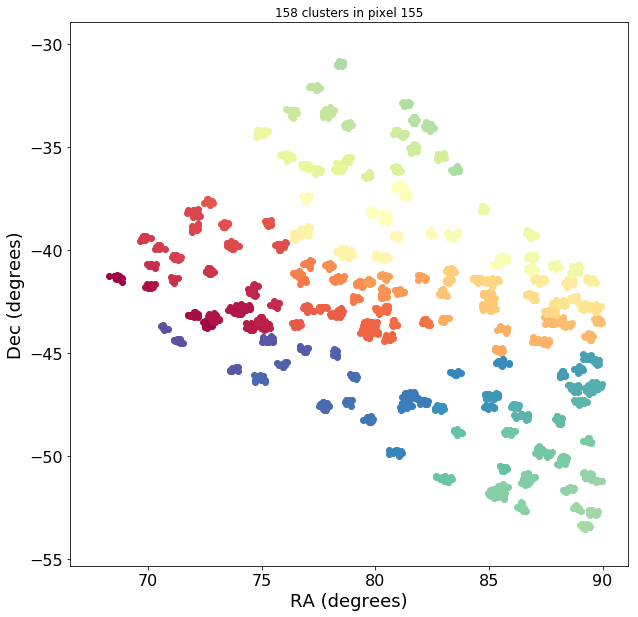

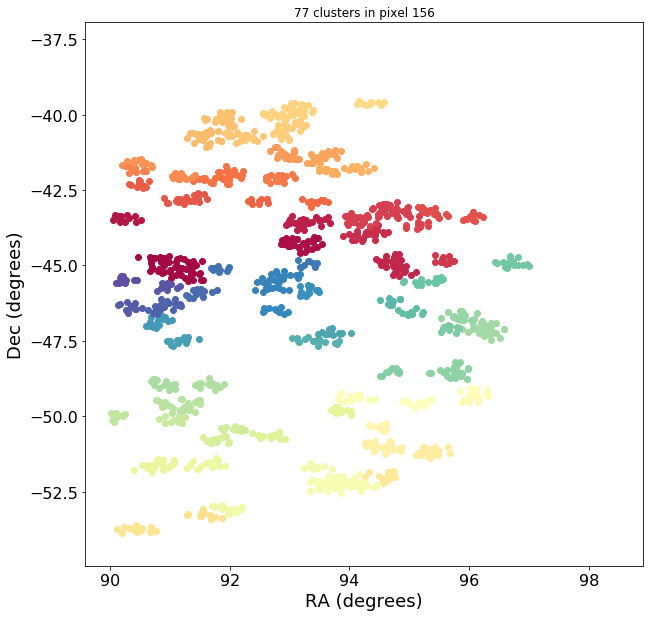

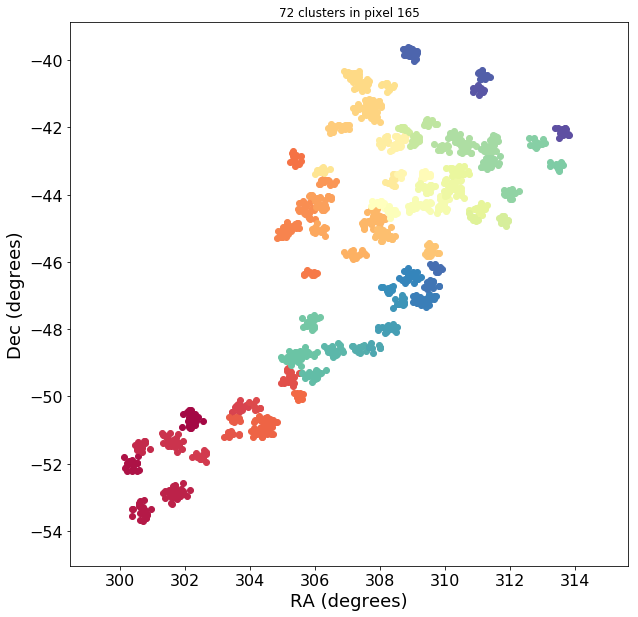

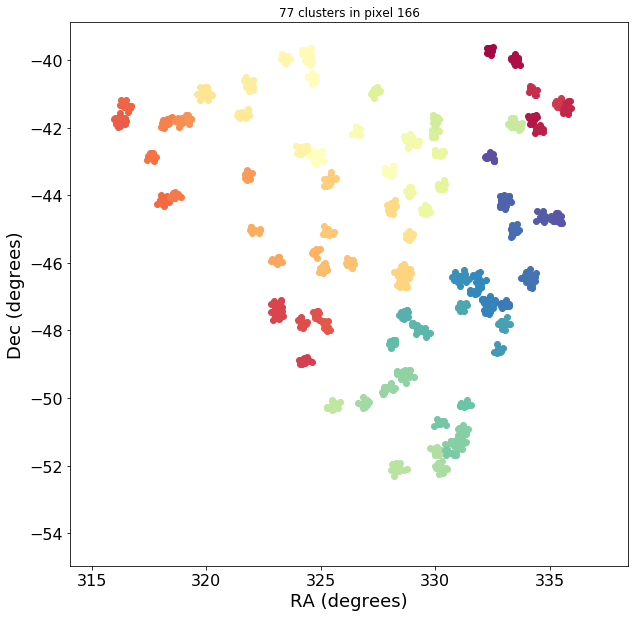

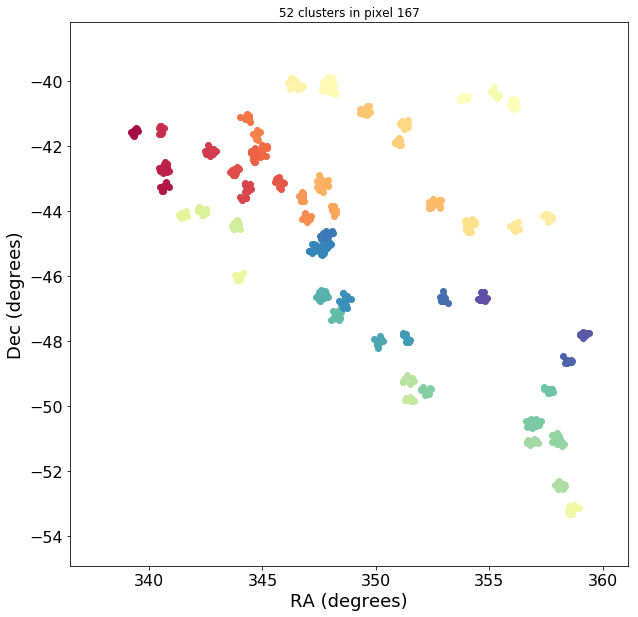

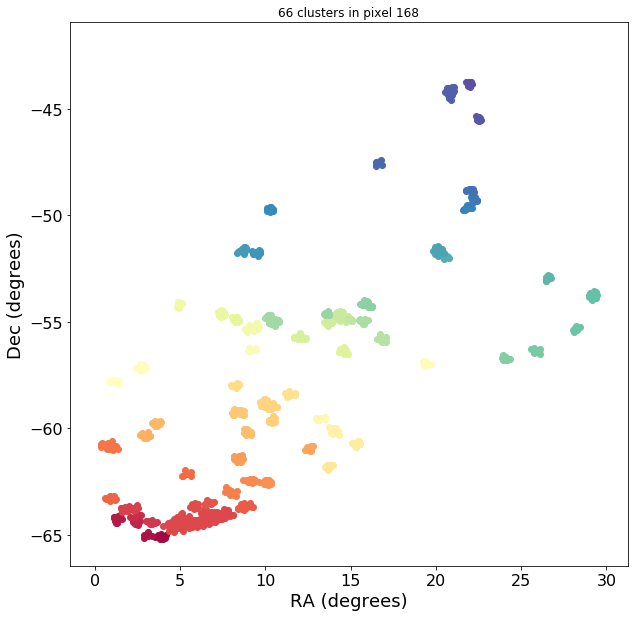

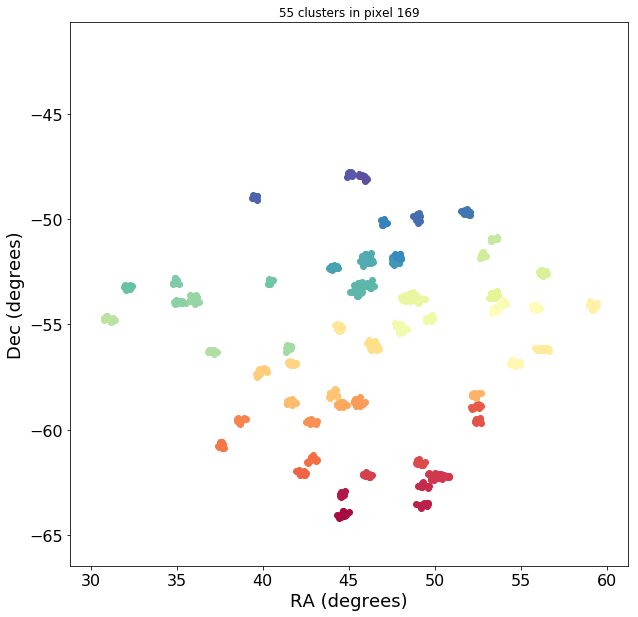

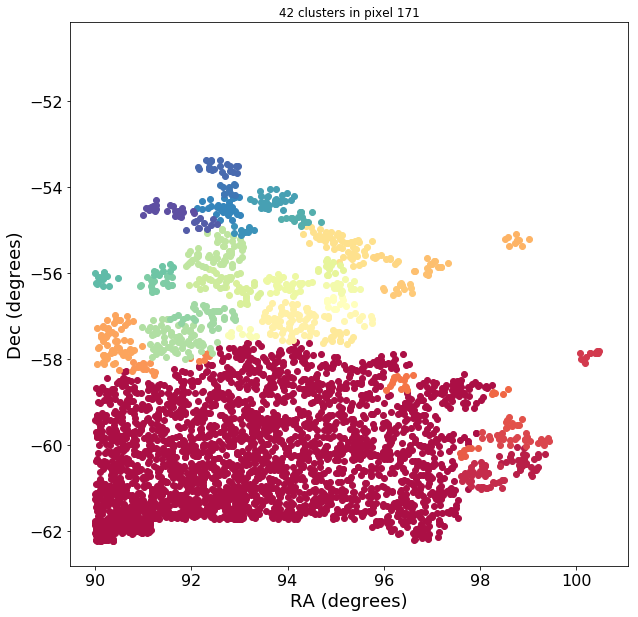

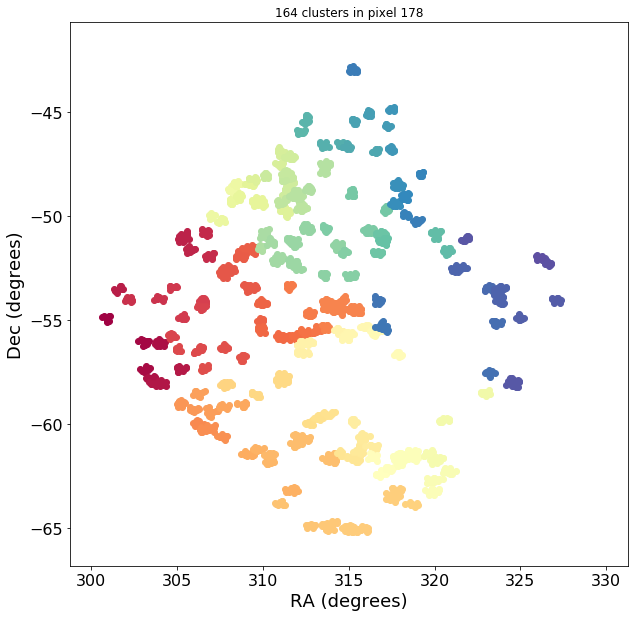

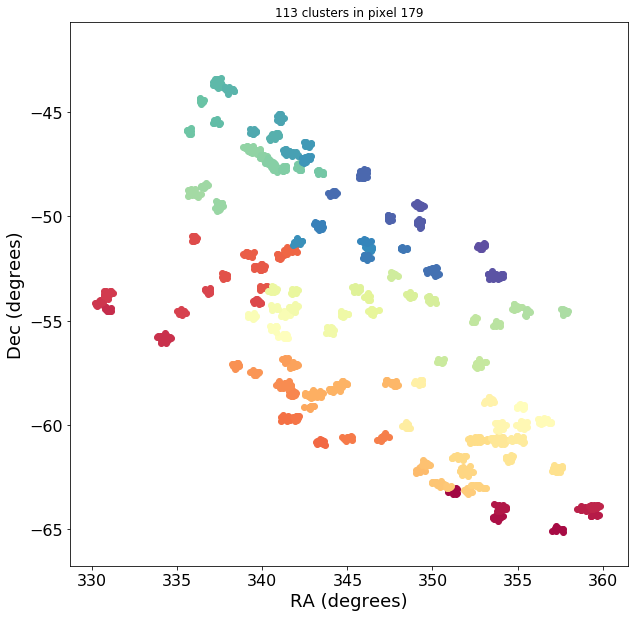

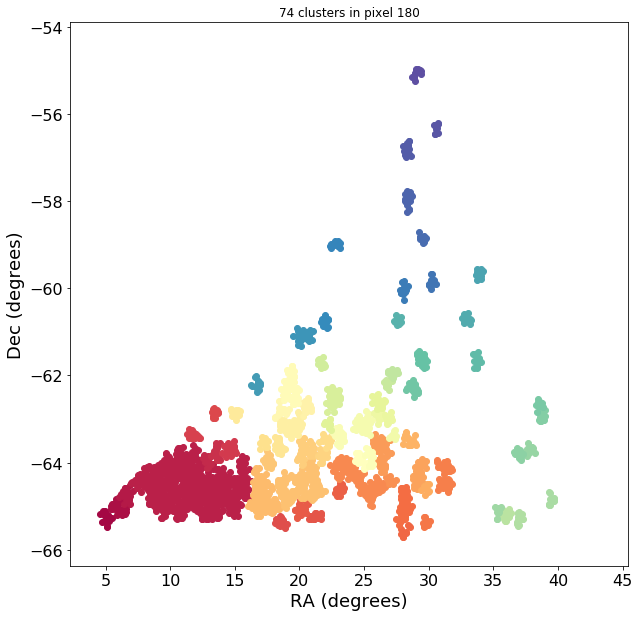

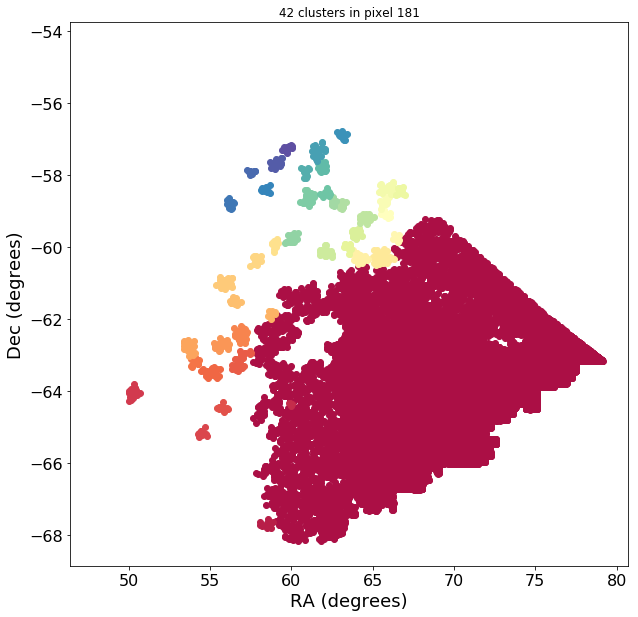

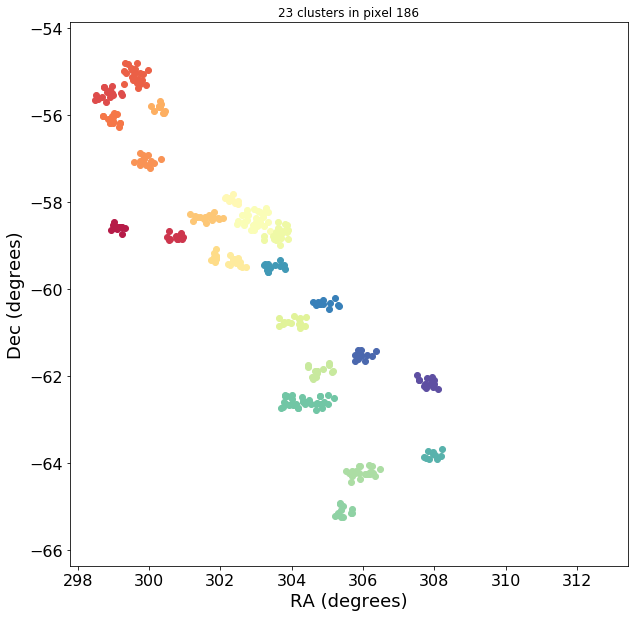

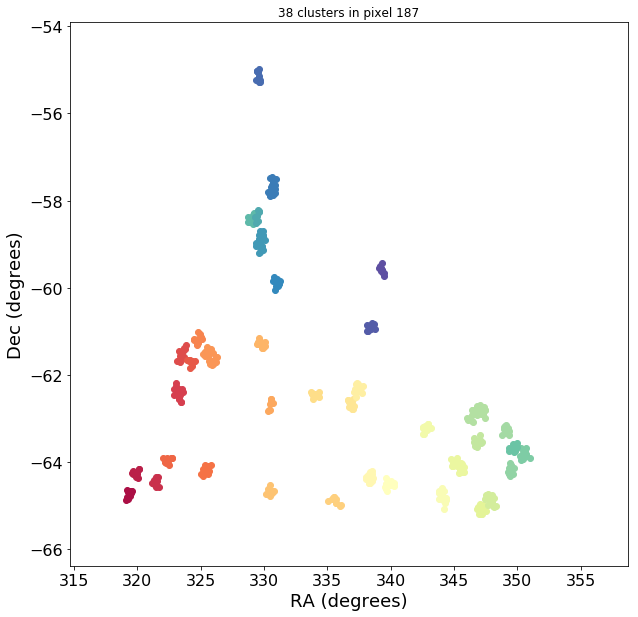

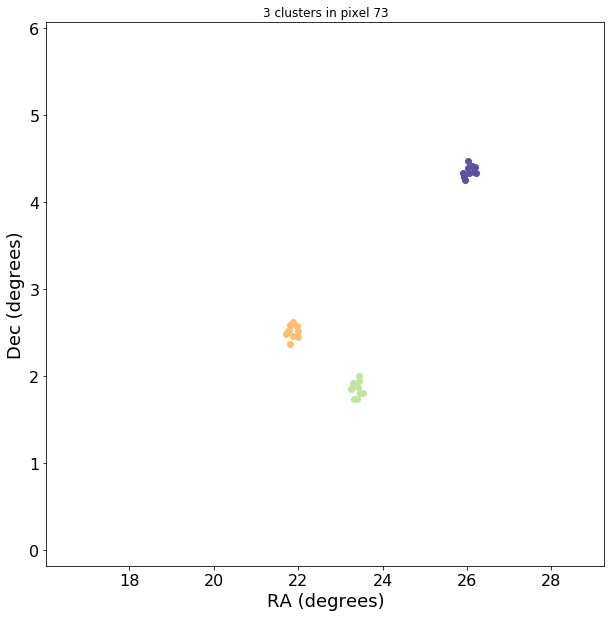

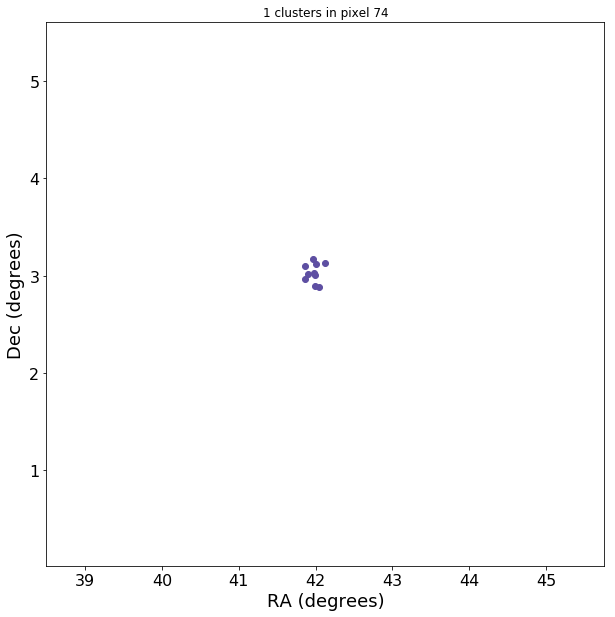

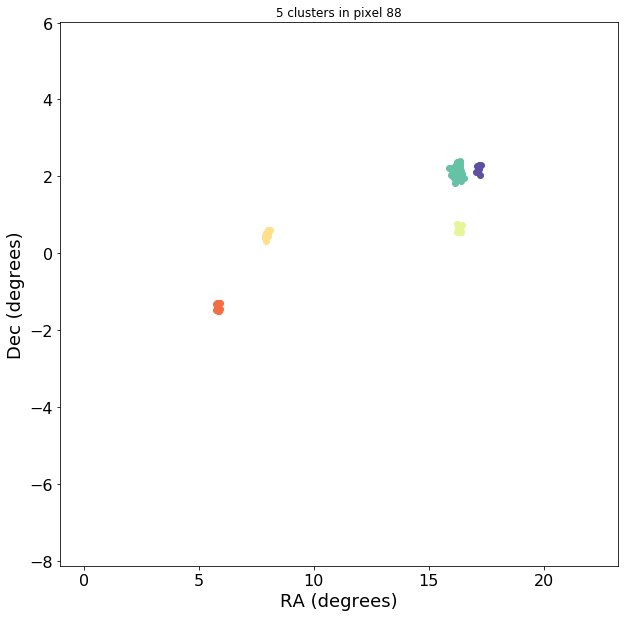

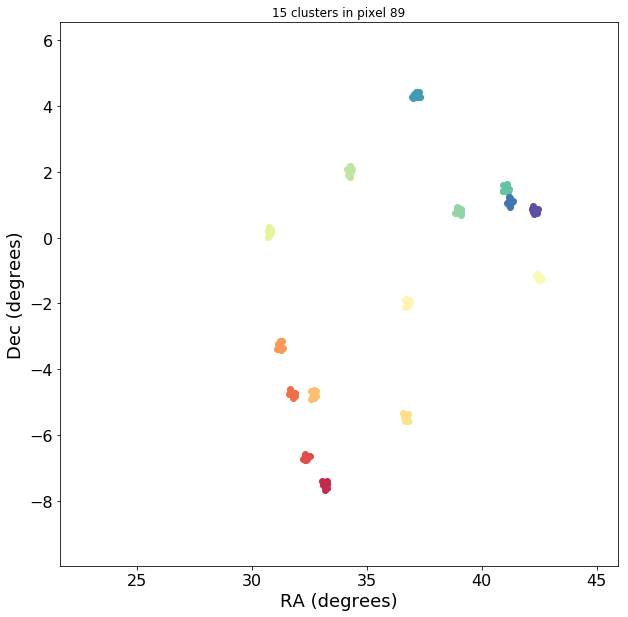

In [72]:
pix_clustercenter = {}

all_files.remove('dbscan_hp4_170.npy') #not plotting pixel 170 because it has too many clusters
for fi in all_files:
    labels = np.load(result_dir+fi)
    current_pix = int(fi.split('_')[-1].split('.')[0])
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters in pixel {}: {}'.format(current_pix, n_clusters_))

    df_current = df[df.pix == current_pix].loc[:,'ra':'mag_auto_i']
    df_current['dblabel'] = labels

    unique_labels = np.unique(labels)
    core_samples_center = np.zeros((len(unique_labels)-1,2))
    for j in np.arange(len(unique_labels)-1):
        x = df_current[df_current.dblabel == j].loc[:,'ra':'dec']
        core_samples_center[j,:] = np.mean(x, axis=0)
    pix_clustercenter[current_pix] = core_samples_center
    
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(10,10))

    for k, col in zip(unique_labels, colors):
        if k == -1:
        # Black used for noise.
            col = [0, 0, 0, 0]

        xy = df_current[df_current.dblabel == k].loc[:,'ra':'dec']
        plt.plot(xy['ra'], xy['dec'], 'o', markerfacecolor=tuple(col),markeredgecolor=tuple(col),
             markersize=6)

    plt.tick_params(axis='both',labelsize=16)
    plt.xlabel('RA (degrees)',fontsize=18)
    plt.ylabel('Dec (degrees)',fontsize=18)
    plt.title('{} clusters in pixel {}'.format(n_clusters_, current_pix))
    #plt.show()
    plt.savefig(plot_dir+'cluster_plot_hpix4_{}.png'.format(current_pix))
    

# Appendix
This is how we assigned pixel tags to the 'des_dr1_g_i_small_box_hpix_4.csv' file.

we calculated the df['pix'] column from healpix with nside = 4

In [ ]:
## a convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [4]:
def angular_separation(x1,x2):
    """
    Modified from astropy.coordinates.angle_utilities 
    Angular separation between two points on a sphere.
    Parameters
    ----------
    x1, x2: array of float Longitude and latitude in radians.
    each array needs to have two columns, lon(RA) and lat(dec)
    Returns
    -------
    angular separation: float in radians.
    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1]_,
    which is slightly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.
    .. [1] https://en.wikipedia.org/wiki/Great-circle_distance
    """
    sdlon = np.sin(x2[0] - x1[0])
    cdlon = np.cos(x2[0] - x1[0])
    slat1 = np.sin(x1[1])
    slat2 = np.sin(x2[1])
    clat1 = np.cos(x1[1])
    clat2 = np.cos(x2[1])

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)
   

In [5]:
def angular_separation_hvs(x1,x2):
    """
    Modified from astropy.coordinates.angle_utilities 
    Angular separation between two points on a sphere.
    Parameters
    ----------
    x1, x2: array of float Longitude and latitude in radians.
    each array needs to have two columns, lon(RA)(lambda) and lat(dec)(phi)
    Returns
    -------
    angular separation: float in radians.
    Notes
    -----
    The angular separation is calculated using the Haversine formula [1]_,
    which is computationally less expensive than
    Vincenty, but is not stable at antipodes.
    .. [1] https://en.wikipedia.org/wiki/Great-circle_distance
    """
    ssqrdlat = np.sin(0.5*(x2[1] - x1[1]))**2
    ssqrdlon = np.sin(0.5*(x2[0] - x1[0]))**2
    clat1 = np.cos(x1[1])
    clat2 = np.cos(x2[1])
    
    return 2*np.arcsin(np.sqrt(ssqrdlat + clat1*clat2*ssqrdlon))
    

In [9]:
# Healpix resolution parameters
n_exp = 2
nside = 2**n_exp #Drlica-Wagner 2015: nside = 4096
npix = 12 * 4**n_exp

print (n_exp,nside,npix)

2 4 192


In [18]:
import collections
# Calculate the area of one pixel (check against size of galaxies)
area = hp.nside2pixarea(nside,degrees=True)
print('area of each pixel = ',area)

# Read in the ra and dec coordinates for each star
lon,lat = df['ra'],df['dec']
df['pix'] = hp.ang2pix(nside,lon,lat,lonlat=True) # Convert to healpy pixel position

# Count how many stars in each pixel
counts = collections.Counter(df['pix'])
pixels, number = np.array(sorted(counts.items())).T

area of each pixel =  214.8591731740587
